In [1]:
import pandas as pd
import geopandas as gd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import rasterio
import rasterio.warp
from rasterio import features
import shapely.geometry
import shapely
import seaborn as sn

In [2]:
os.chdir('/projects/canis/eoc_feature_corr')

In [3]:
grid_path = "./data/by_state/OR/or_extent_coverage.shp"
grid = gd.read_file(grid_path)
grid = grid.set_index('id')

In [7]:
feature_path = './data/cover/NLCD_2016_Land_Cover_L48_20190424_3857.tiff'

feature_file = rasterio.open(feature_path)
feature_raster = feature_file.read(1)

In [8]:
feature_legend_path = './data/cover/NLCD_landcover_legend_2018_12_17_IGrpwzCAkFkyZtKBIu8z.csv'
feature_legend = pd.read_csv(feature_legend_path)
feature_legend = feature_legend.set_index('Value')
feature_legend = feature_legend.dropna()

In [9]:
feature_legend

,Legend
Value,
0,Unclassified
11,Open Water
12,Perennial Snow/Ice
21,"Developed, Open Space"
22,"Developed, Low Intensity"
23,"Developed, Medium Intensity"
24,"Developed, High Intensity"
31,Barren Land
41,Deciduous Forest


In [10]:
grid['centroid'] = grid['geometry'].centroid
grid = grid.set_geometry('centroid')
grid['feature'] = grid['centroid'].map(lambda coords: next(feature_file.sample(coords.coords, indexes=1))[0])
grid = grid.set_geometry('geometry')
grid = grid.drop('centroid', axis=1)
grid

,left,top,right,bottom,med_rxpwr,chg_covera,verizon_co,geometry,feature
id,,,,,,,,,
130.0,-1.370092e+07,5.619686e+06,-1.369992e+07,5.618686e+06,-115.975,0,1,"POLYGON ((-13700919.062 5619685.577, -13699919...",23
131.0,-1.370092e+07,5.618686e+06,-1.369992e+07,5.617686e+06,-106.430,1,1,"POLYGON ((-13700919.062 5618685.577, -13699919...",22
1010.0,-1.369892e+07,5.615686e+06,-1.369792e+07,5.614686e+06,-99.715,1,1,"POLYGON ((-13698919.062 5615685.577, -13697919...",22
1011.0,-1.369892e+07,5.614686e+06,-1.369792e+07,5.613686e+06,-104.800,1,1,"POLYGON ((-13698919.062 5614685.577, -13697919...",21
1012.0,-1.369892e+07,5.613686e+06,-1.369792e+07,5.612686e+06,-96.780,1,1,"POLYGON ((-13698919.062 5613685.577, -13697919...",24
...,...,...,...,...,...,...,...,...,...
298996.0,-1.301892e+07,5.469686e+06,-1.301792e+07,5.468686e+06,-87.690,1,1,"POLYGON ((-13018919.062 5469685.577, -13017919...",23
298997.0,-1.301892e+07,5.468686e+06,-1.301792e+07,5.467686e+06,-96.680,1,1,"POLYGON ((-13018919.062 5468685.577, -13017919...",21
298998.0,-1.301892e+07,5.467686e+06,-1.301792e+07,5.466686e+06,-83.085,1,1,"POLYGON ((-13018919.062 5467685.577, -13017919...",71


In [11]:
grid = grid.join(feature_legend, how="left", on='feature')

In [12]:
grid['agreement'] = grid['chg_covera'] == grid['verizon_co']

In [13]:
sn.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

In [14]:
confusion_matrix = pd.crosstab( grid['Legend'],grid['agreement'], rownames=['Cover Type'], colnames=['Agreement'], normalize='index')
print (confusion_matrix)

Agreement                         False     True 
Cover Type                                       
Barren Land                    0.333333  0.666667
Cultivated Crops               0.317940  0.682060
Deciduous Forest               0.400000  0.600000
Developed, High Intensity      0.000000  1.000000
Developed, Low Intensity       0.359551  0.640449
Developed, Medium Intensity    0.250000  0.750000
Developed, Open Space          0.366197  0.633803
Emergent Herbaceuous Wetlands  0.725000  0.275000
Evergreen Forest               0.762658  0.237342
Hay/Pasture                    0.371002  0.628998
Herbaceuous                    0.551532  0.448468
Mixed Forest                   0.636364  0.363636
Open Water                     0.666667  0.333333
Shrub/Scrub                    0.565511  0.434489
Woody Wetlands                 0.645161  0.354839


In [15]:
confusion_matrix['Total'] = grid.groupby('Legend').count()['agreement']

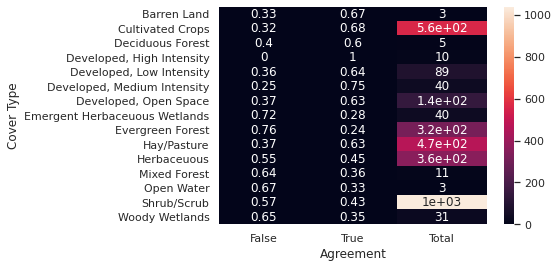

In [16]:
sn.heatmap(confusion_matrix, annot=True)
plt.show()

Agreement                      False  True   All
Cover Type                                      
Barren Land                        1     2     3
Cultivated Crops                 179   384   563
Deciduous Forest                   2     3     5
Developed, High Intensity          0    10    10
Developed, Low Intensity          32    57    89
Developed, Medium Intensity       10    30    40
Developed, Open Space             52    90   142
Emergent Herbaceuous Wetlands     29    11    40
Evergreen Forest                 241    75   316
Hay/Pasture                      174   295   469
Herbaceuous                      198   161   359
Mixed Forest                       7     4    11
Open Water                         2     1     3
Shrub/Scrub                      587   451  1038
Woody Wetlands                    20    11    31
All                             1534  1585  3119


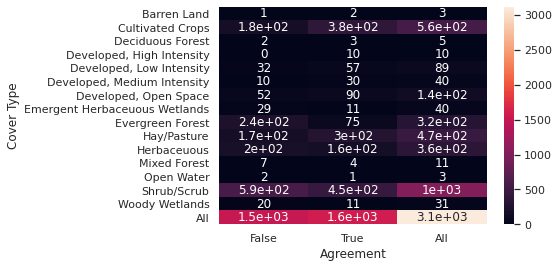

In [17]:
confusion_matrix = pd.crosstab( grid['Legend'],grid['agreement'], rownames=['Cover Type'], colnames=['Agreement'], margins=True)
print (confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)
plt.show()